<a href="https://colab.research.google.com/github/vikas-hkk/Lild4o0d8/blob/main/DL_(Finbert).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers pandas numpy torch sentencepiece

In [ ]:
import pandas as pd
import numpy as np
import re
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

In [ ]:
# Load dataset
df = pd.read_excel("/content/nlp_text_data.xlsx")

# Clean text data (critical for FinBERT)
def clean_text(text):
    # Remove URLs, special characters, and extra spaces
    text = re.sub(r'http\S+', '', str(text))  # Remove URLs
    text = re.sub(r'[^a-zA-Z0-9\s.,;:!?]', '', text)  # Remove special characters except punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

# Apply cleaning to 'text' and 'title' columns
df['cleaned_text'] = df['text'].apply(clean_text)
df['cleaned_title'] = df['title'].apply(clean_text)

In [ ]:
# Load FinBERT model and tokenizer
model_name = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Create sentiment analysis pipeline
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model=model,
    tokenizer=tokenizer,
    device=0 if torch.cuda.is_available() else -1  # Use GPU if available
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Device set to use cpu


In [ ]:
# Function to get sentiment scores
def get_sentiment(text):
    try:
        result = sentiment_pipeline(text, truncation=True, max_length=512)
        return result[0]['label'], result[0]['score']
    except:
        return "neutral", 0.0  # Fallback for empty text

# Apply to cleaned text
df[['sentiment_label', 'sentiment_score']] = df['cleaned_text'].apply(
    lambda x: pd.Series(get_sentiment(x))
)

# Map labels to numerical values (optional)
sentiment_mapping = {'positive': 1, 'neutral': 0, 'negative': -1}
df['sentiment_numeric'] = df['sentiment_label'].map(sentiment_mapping)

In [ ]:
df.to_csv("processed_data_with_sentiment.csv", index=False)

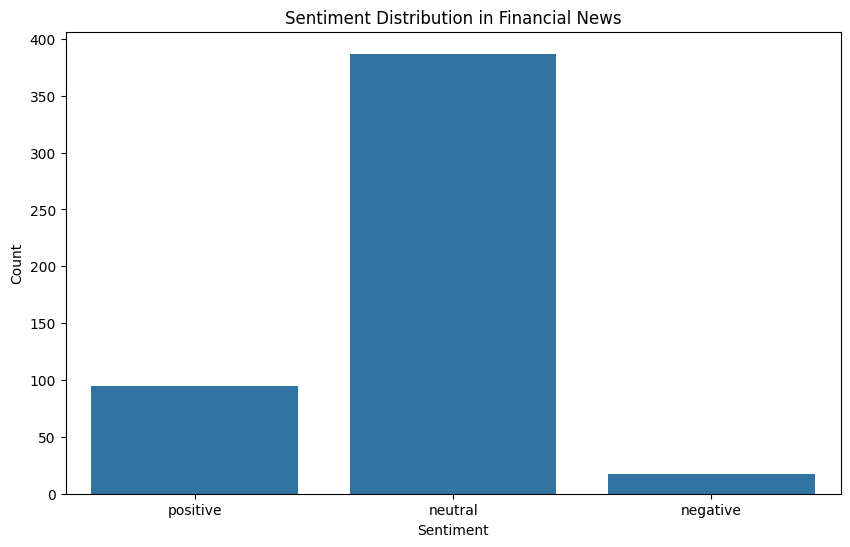

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot sentiment distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='sentiment_label', order=['positive', 'neutral', 'negative'])
plt.title("Sentiment Distribution in Financial News")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

In [ ]:
!pip install yfinance matplotlib pandas


[*********************100%***********************]  1 of 1 completed


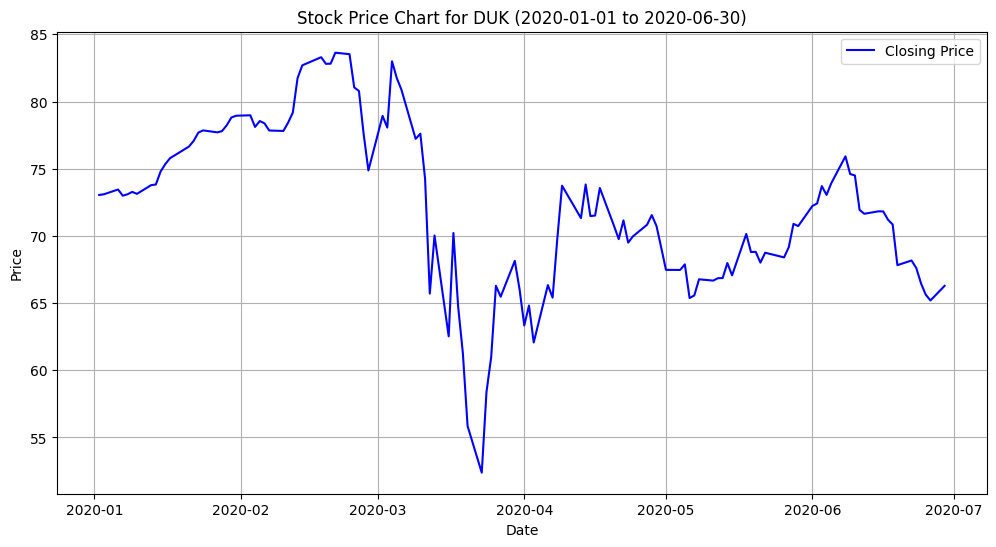

In [ ]:
import yfinance as yf
import matplotlib.pyplot as plt

# Define the ticker and date range
ticker = "DUK"  # Change this to your desired stock symbol
start_date = "2020-01-01"
end_date = "2020-06-30"

# Download stock data
stock_data = yf.download(ticker, start=start_date, end=end_date)

# Check if data is available
if stock_data.empty:
    print(f"No data found for {ticker}. Check the ticker symbol and try again.")
else:
    # Plot the stock closing prices
    plt.figure(figsize=(12, 6))
    plt.plot(stock_data.index, stock_data['Close'], label="Closing Price", color='blue')
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.title(f"Stock Price Chart for {ticker} ({start_date} to {end_date})")
    plt.legend()
    plt.grid()
    plt.show()


In [ ]:
import yfinance as yf
import plotly.graph_objects as go
import pandas as pd

# Define stock ticker and date range
ticker = "MSFT"  # Duke Energy (NYSE)
start_date = "2020-01-01"
end_date = "2020-06-30"

# Fetch stock data
df = yf.download("MSFT", start="2020-01-01", end="2020-06-30", group_by="ticker")

# Flatten MultiIndex if needed
if isinstance(df.columns, pd.MultiIndex):
    df.columns = [col[1] for col in df.columns]  # Keep only the first level (Price Type)

# Debug: Check columns again
print(df.head())
print(df.columns)  # Should now be ['Open', 'High', 'Low', 'Close', 'Volume']


# Convert timezone only if not already localized
if df.index.tz is None:
    df.index = df.index.tz_localize('UTC').tz_convert('America/New_York')

# Ensure Open, High, Low, Close columns exist
if {'Open', 'High', 'Low', 'Close'}.issubset(df.columns):
    # Create candlestick chart
    fig = go.Figure(data=[go.Candlestick(
        x=df.index,
        open=df['Open'],
        high=df['High'],
        low=df['Low'],
        close=df['Close'],
        increasing_line_color='green',
        decreasing_line_color='red'
    )])

    # Chart layout
    fig.update_layout(title=f"{ticker} Candlestick Chart", xaxis_title="Date", yaxis_title="Price")

    # Show chart
    fig.show()
else:
    print("Error: Open, High, Low, Close columns are missing!")


[*********************100%***********************]  1 of 1 completed

                  Open        High         Low       Close    Volume
Date                                                                
2020-01-02  151.566865  153.428276  151.137310  153.323273  22622100
2020-01-03  151.127764  152.683705  150.879566  151.414124  21116200
2020-01-06  149.944100  151.872338  149.399987  151.805511  20813700
2020-01-07  152.082346  152.416438  150.173203  150.421387  21634100
2020-01-08  151.710046  153.495104  150.774570  152.817352  27746500
Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')


In [ ]:
import yfinance as yf
import plotly.graph_objects as go
import pandas as pd
import os
from datetime import datetime, timedelta

# Create directory to save images
os.makedirs('candlestick_images', exist_ok=True)

# Define stock ticker and date range
ticker = "DUK"  # Duke Energy (NYSE)
start_date = "2020-01-01"
end_date = "2020-06-30"

# Fetch stock data (ensure '1d' interval for daily data)
try:
    full_df = yf.download(ticker, start=start_date, end=end_date, interval="1d")
    print("Data downloaded successfully.")
    print(full_df.head())  # Debug: Check columns
except Exception as e:
    print(f"Failed to download data: {e}")
    exit()

# Check if required columns exist
required_columns = ['Open', 'High', 'Low', 'Close']
if not all(col in full_df.columns for col in required_columns):
    print("Error: Missing required columns in DataFrame.")
    print(f"Available columns: {full_df.columns.tolist()}")
    exit()

# Drop rows with missing values
full_df = full_df.dropna()

# Convert timezone if needed
if full_df.index.tz is None:
    full_df.index = full_df.index.tz_localize('UTC').tz_convert('America/New_York')

# Function to generate and save candlestick charts
def generate_candlestick_images(df, ticker, window_size=20, stride=5, img_folder='candlestick_images'):
    """
    Generate candlestick images for sliding windows of data.

    Args:
        df (pd.DataFrame): Stock price data (must contain 'Open', 'High', 'Low', 'Close')
        ticker (str): Stock symbol (for filename)
        window_size (int): Number of trading days per image (default: 20)
        stride (int): Days to shift window (default: 5)
        img_folder (str): Folder to save images
    """
    total_days = len(df)
    image_count = 0

    if total_days < window_size:
        print(f"Not enough data points ({total_days}) for window size {window_size}.")
        return 0

    for i in range(0, total_days - window_size + 1, stride):
        window_df = df.iloc[i:i + window_size]

        # Ensure the window has enough data points
        if len(window_df) != window_size:
            print(f"Skipping incomplete window: {window_df.index[0].date()} to {window_df.index[-1].date()}")
            continue

        fig = go.Figure(data=[go.Candlestick(
            x=window_df.index,
            open=window_df['Open'],
            high=window_df['High'],
            low=window_df['Low'],
            close=window_df['Close'],
            increasing_line_color='green',
            decreasing_line_color='red'
        )])

        # Customize layout
        fig.update_layout(
            title=f"{ticker} {window_df.index[0].date()} to {window_df.index[-1].date()}",
            xaxis_title="Date",
            yaxis_title="Price (USD)",
            xaxis_rangeslider_visible=False,
            width=800,
            height=600,
            margin=dict(l=50, r=50, t=80, b=50),
            plot_bgcolor='white',
            paper_bgcolor='white'
        )

        # Format axes
        fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')
        fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')

        # Remove weekends (non-trading days)
        fig.update_xaxes(rangebreaks=[dict(bounds=["sat", "mon"])])

        # Save image
        start_date_str = window_df.index[0].strftime('%Y%m%d')
        end_date_str = window_df.index[-1].strftime('%Y%m%d')
        img_path = os.path.join(img_folder, f"{ticker}_{start_date_str}_{end_date_str}.png")

        try:
            fig.write_image(img_path, engine='kaleido')
            image_count += 1
            print(f"✅ Saved image {image_count}: {img_path}")
        except Exception as e:
            print(f"❌ Failed to save {img_path}: {e}")

    return image_count

# Generate images (20-day window, 5-day stride)
num_images = generate_candlestick_images(full_df, ticker, window_size=20, stride=5)
print(f"\n🎉 Successfully generated {num_images} candlestick images in 'candlestick_images' folder.")

[*********************100%***********************]  1 of 1 completed


Data downloaded successfully.
Price           Close       High        Low       Open   Volume
Ticker            DUK        DUK        DUK        DUK      DUK
Date                                                           
2020-01-02  73.049805  74.214205  72.799138  73.809900  3921800
2020-01-03  73.098320  73.640087  72.896168  72.960858  2825400
2020-01-06  73.454117  73.615842  73.017473  73.098333  2410300
2020-01-07  72.993210  73.494550  72.645507  73.494550  3980900
2020-01-08  73.098320  73.478368  72.742530  73.146835  2583300
✅ Saved image 1: candlestick_images/DUK_20200101_20200129.png
✅ Saved image 2: candlestick_images/DUK_20200108_20200205.png
✅ Saved image 3: candlestick_images/DUK_20200115_20200212.png
✅ Saved image 4: candlestick_images/DUK_20200123_20200220.png
✅ Saved image 5: candlestick_images/DUK_20200130_20200227.png
✅ Saved image 6: candlestick_images/DUK_20200206_20200305.png
✅ Saved image 7: candlestick_images/DUK_20200213_20200312.png
✅ Saved image 8: candles

In [ ]:
import yfinance as yf
import plotly.graph_objects as go
import pandas as pd
import os
from datetime import datetime, timedelta

# Configuration
ticker = "MSFT"
folder_name = "msft_candlestick"
window_size = 20  # Optimal for ViT/CNN
stride = 3        # Overlapping windows for more images
min_images = 200  # Target number of images

# Create directory
os.makedirs(folder_name, exist_ok=True)

# Calculate required date range (extend until we get enough data)
end_date = datetime.now().strftime('%Y-%m-%d')
start_date = "2010-01-01"  # Start with 13+ years of data

# Fetch data
print(f"Downloading {ticker} data from {start_date} to {end_date}...")
df = yf.download(ticker, start=start_date, end=end_date, interval="1d")

# Data cleaning
df = df.dropna()
if df.index.tz is None:
    df.index = df.index.tz_localize('UTC').tz_convert('America/New_York')

# Verify columns
required_cols = ['Open', 'High', 'Low', 'Close']
assert all(col in df.columns for col in required_cols), \
       f"Missing columns. Available: {df.columns.tolist()}"

# Adjust stride to hit target image count
total_possible = (len(df) - window_size) // stride
if total_possible < min_images:
    new_stride = max(1, (len(df) - window_size) // min_images)
    print(f"Adjusting stride from {stride} to {new_stride} to reach {min_images} images")
    stride = new_stride

# Image generation function
def generate_images():
    image_count = 0
    for i in range(0, len(df) - window_size + 1, stride):
        window = df.iloc[i:i+window_size]

        fig = go.Figure(go.Candlestick(
            x=window.index,
            open=window['Open'],
            high=window['High'],
            low=window['Low'],
            close=window['Close'],
            increasing_line_color='green',
            decreasing_line_color='red'
        ))

        fig.update_layout(
            title=f"{ticker} {window.index[0].date()} to {window.index[-1].date()}",
            xaxis_rangeslider_visible=False,
            width=800,
            height=600,
            margin=dict(l=20, r=20, t=50, b=20),
            plot_bgcolor='white'
        )

        filename = f"{folder_name}/{ticker}_{window.index[0].date()}_{window.index[-1].date()}.png"
        fig.write_image(filename, engine='kaleido')
        image_count += 1

        if image_count % 50 == 0:
            print(f"Generated {image_count} images...")

    return image_count

# Execute
print(f"\nGenerating images with {window_size}-day windows...")
generated_count = generate_images()
print(f"\nSuccessfully created {generated_count} images in '{folder_name}' folder")

# Verify minimum target
if generated_count < min_images:
    print("\nWarning: Couldn't reach target of 200 images.")
    print(f"Consider reducing window_size below {window_size} or extending date range further back.")
else:
    print("\nTarget of 200+ images achieved!")

[*********************100%***********************]  1 of 1 completed



Generating images with 20-day windows...
Generated 50 images...
Generated 100 images...
Generated 150 images...
Generated 200 images...
Generated 250 images...
Generated 300 images...
Generated 350 images...
Generated 400 images...
Generated 450 images...
Generated 500 images...
Generated 550 images...
Generated 600 images...
Generated 650 images...
Generated 700 images...
Generated 750 images...
Generated 800 images...
Generated 850 images...
Generated 900 images...
Generated 950 images...
Generated 1000 images...
Generated 1050 images...
Generated 1100 images...
Generated 1150 images...
Generated 1200 images...
Generated 1250 images...

Successfully created 1273 images in 'msft_candlestick' folder

Target of 200+ images achieved!


In [ ]:
import yfinance as yf
import plotly.graph_objects as go
import pandas as pd
import os
import shutil
from datetime import datetime, timedelta
from IPython.display import FileLink  # For Jupyter notebook download

# Configuration
ticker = "MSFT"
folder_name = "msft_candlestick"
window_size = 20  # Optimal for ViT/CNN
stride = 3        # Overlapping windows for more images
max_images = 500  # Stop after this many images

# Create directory
if os.path.exists(folder_name):
    shutil.rmtree(folder_name)  # Clear existing folder
os.makedirs(folder_name, exist_ok=True)

# Date range (extended to ensure enough data)
end_date = datetime.now().strftime('%Y-%m-%d')
start_date = "2000-01-01"  # 23+ years of data for 500+ windows

# Fetch data
print(f"Downloading {ticker} data from {start_date} to {end_date}...")
df = yf.download(ticker, start=start_date, end=end_date, interval="1d")

# Data cleaning
df = df.dropna()
if df.index.tz is None:
    df.index = df.index.tz_localize('UTC').tz_convert('America/New_York')

# Verify columns
required_cols = ['Open', 'High', 'Low', 'Close']
assert all(col in df.columns for col in required_cols), \
       f"Missing columns. Available: {df.columns.tolist()}"

# Image generation with early stopping
def generate_images():
    image_count = 0
    for i in range(0, len(df) - window_size + 1, stride):
        if image_count >= max_images:
            break

        window = df.iloc[i:i+window_size]

        fig = go.Figure(go.Candlestick(
            x=window.index,
            open=window['Open'],
            high=window['High'],
            low=window['Low'],
            close=window['Close'],
            increasing_line_color='green',
            decreasing_line_color='red'
        ))

        fig.update_layout(
            title=f"{ticker} {window.index[0].date()} to {window.index[-1].date()}",
            xaxis_rangeslider_visible=False,
            width=800,
            height=600,
            margin=dict(l=20, r=20, t=50, b=20),
            plot_bgcolor='white'
        )

        filename = f"{folder_name}/{ticker}_{window.index[0].strftime('%Y%m%d')}_{window.index[-1].strftime('%Y%m%d')}.png"
        fig.write_image(filename, engine='kaleido')
        image_count += 1

        if image_count % 100 == 0:
            print(f"Generated {image_count}/{max_images} images...")

    return image_count

# Execute
print(f"\nGenerating max {max_images} images with {window_size}-day windows...")
generated_count = generate_images()

# Create ZIP archive
shutil.make_archive(folder_name, 'zip', folder_name)
print(f"\nSuccessfully created {generated_count} images")
print(f"ZIP archive created: {folder_name}.zip")

# For Jupyter notebook download
display(FileLink(f"{folder_name}.zip"))

[*********************100%***********************]  1 of 1 completed



Generating max 500 images with 20-day windows...
Generated 100/500 images...
Generated 200/500 images...
Generated 300/500 images...
Generated 400/500 images...
Generated 500/500 images...

Successfully created 500 images
ZIP archive created: msft_candlestick.zip


/content/msft_candlestick.zip